## Vehicle Detection Project

In [1]:
import numpy as np

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import pickle
import cv2
import glob
import time

%matplotlib inline

print('...')

...


### Load Data

In [4]:
car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### Show some images

In [15]:
def imread(img_path, color_space=cv2.COLOR_BGR2RGB):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, color_space)
    return img

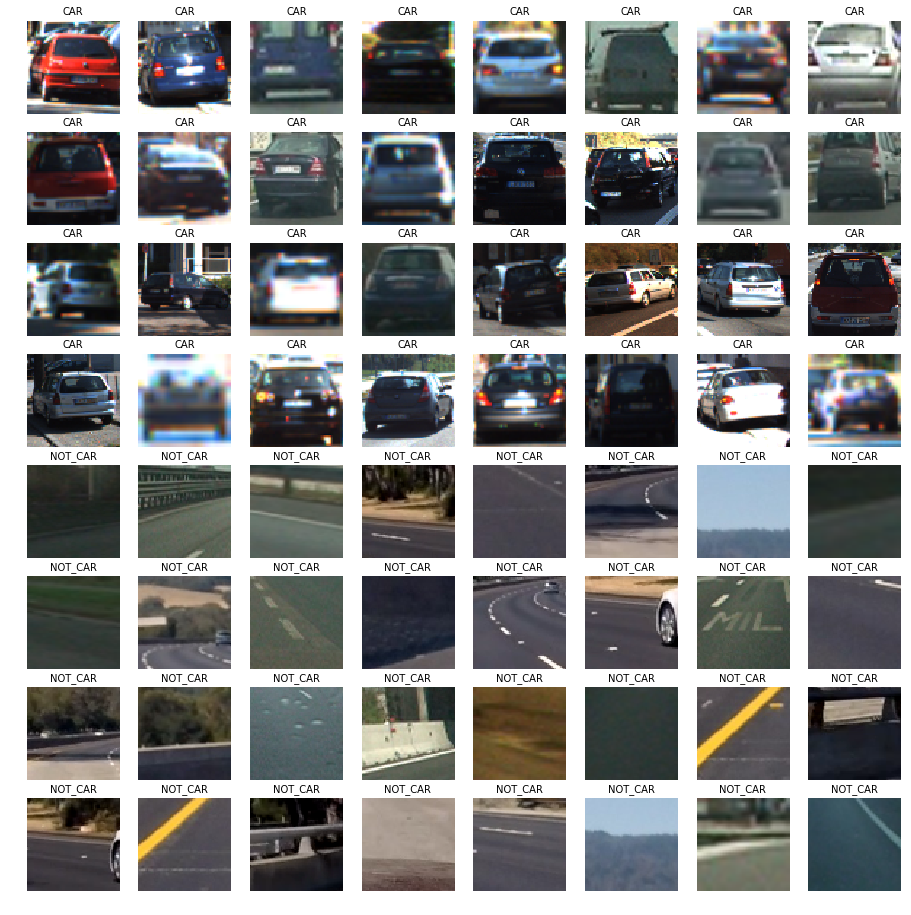

In [8]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
fig.subplots_adjust(hspace=.2, wspace = .001)
axes = axes.ravel()

for i in np.arange(32):
    img = imread(car_images[np.random.randint(0, len(car_images))])
    axes[i].axis('off')
    axes[i].set_title("CAR", fontsize=10)
    axes[i].imshow(img)
    
for i in np.arange(32, 64):
    img = imread(noncar_images[np.random.randint(0, len(noncar_images))])
    axes[i].axis('off')
    axes[i].set_title("NOT_CAR", fontsize=10)
    axes[i].imshow(img)

In [10]:
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
    return features

def extract_hog_features_visualise(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features, hog_image = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=True, feature_vector=feature_vec)
    return features, hog_image

...


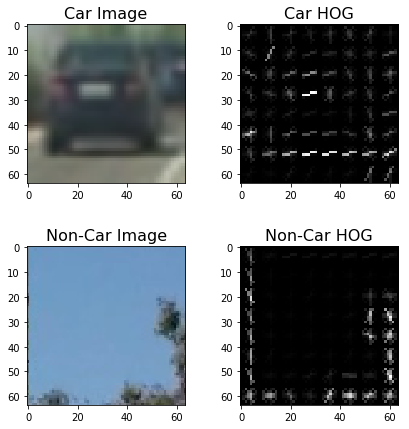

In [14]:
car_img = mpimg.imread(car_images[0])
_, car_dst = extract_hog_features_visualise(car_img[:,:,2], 9, 8, 8, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[0])
_, noncar_dst = extract_hog_features_visualise(noncar_img[:,:,2], 9, 8, 8, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

In [21]:
def extract_features(imgs, color_space="RGB", orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        if color_space == 'HSV':
            feature_image = imread(file, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = imread(file, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = imread(file, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = imread(file, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = imread(file, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = imread(file)
            
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(extract_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    feature_vec=True))
            hog_features = np.ravel(hog_features) 
        else:
            hog_features = extract_hog_features(feature_image[:,:,hog_channel],
                                                orient, 
                                                pix_per_cell, 
                                                cell_per_block, 
                                                feature_vec=True)
            
        features.append(hog_features)
        
    return features

In [22]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

71.62 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [23]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.02402 Seconds to predict 10 labels with SVC
